In [5]:
!pip install langdetect

     |████████████████████████████████| 1.0MB 2.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=648e1d1bed035585fe448663df438ccafe24047afc59098bc93529c3b91954bc
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect


In [0]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
from pathlib import Path
import pickle

In [29]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
GDRIVE_DIR = Path("drive/My Drive/Colab Notebooks/transformers/PlotGeneratorGPT2")
DATA_DIR = GDRIVE_DIR/'data'
DATA_DIR.mkdir(exist_ok=True)
DATA_FILE = DATA_DIR/'data.pkl'

## Download data

In [2]:
!rm -rf data
!mkdir data
!wget https://github.com/davidsbatista/text-classification/blob/master/movies_genres.csv.bz2?raw=true -O data/movies_genres.csv.bz2

--2019-11-10 13:00:38--  https://github.com/davidsbatista/text-classification/blob/master/movies_genres.csv.bz2?raw=true
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/davidsbatista/text-classification/raw/master/movies_genres.csv.bz2 [following]
--2019-11-10 13:00:39--  https://github.com/davidsbatista/text-classification/raw/master/movies_genres.csv.bz2
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davidsbatista/text-classification/master/movies_genres.csv.bz2 [following]
--2019-11-10 13:00:40--  https://raw.githubusercontent.com/davidsbatista/text-classification/master/movies_genres.csv.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubuserc

In [0]:
df = pd.read_csv('data/movies_genres.csv.bz2', sep='\t')

## Prepare data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117352 entries, 0 to 117351
Data columns (total 30 columns):
title          117352 non-null object
plot           117352 non-null object
Action         117352 non-null int64
Adult          117352 non-null int64
Adventure      117352 non-null int64
Animation      117352 non-null int64
Biography      117352 non-null int64
Comedy         117352 non-null int64
Crime          117352 non-null int64
Documentary    117352 non-null int64
Drama          117352 non-null int64
Family         117352 non-null int64
Fantasy        117352 non-null int64
Game-Show      117352 non-null int64
History        117352 non-null int64
Horror         117352 non-null int64
Lifestyle      117352 non-null int64
Music          117352 non-null int64
Musical        117352 non-null int64
Mystery        117352 non-null int64
News           117352 non-null int64
Reality-TV     117352 non-null int64
Romance        117352 non-null int64
Sci-Fi         117352 non-null int64

In [9]:
# We want English plots only
plot_langs = []
for plot in tqdm(df['plot']):
    plot_langs.append(detect(plot))

100%|██████████| 117352/117352 [09:21<00:00, 208.90it/s]


In [10]:
df['plot_lang'] = plot_langs
df['plot_lang'].value_counts()

en    117195
nl       120
de        14
it         7
da         5
no         3
pt         2
es         2
fr         2
sv         1
hu         1
Name: plot_lang, dtype: int64

In [0]:
df = df[df['plot_lang'].isin(['en'])]

In [12]:
genre_cols = df.columns.difference(['title', 'plot', 'plot_lang'])

df[genre_cols].sum().sort_values()

Lifestyle          0
Adult             61
Short            578
Musical          595
Biography       1385
War             1407
Sport           1947
Game-Show       2046
Horror          2571
History         2662
Western         2761
Music           2838
News            3945
Talk-Show       5253
Fantasy         7103
Sci-Fi          8658
Thriller        8852
Adventure      10243
Animation      11369
Documentary    12020
Mystery        12025
Reality-TV     12336
Action         12376
Crime          15120
Family         15403
Romance        19174
Comedy         33870
Drama          45890
dtype: int64

In [14]:
# Build list of genres for each row
genre_df = df[genre_cols].astype(bool)
plot_genres = []
for idx, row in tqdm(genre_df.iterrows()):
    plot_genres.append({genre for genre, isset in row.iteritems() if isset})

117195it [00:09, 12434.23it/s]


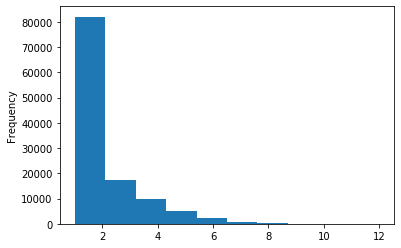

In [15]:
df['genres'] = plot_genres
df['genres'].apply(len).plot.hist()

In [19]:
df = df[['title', 'plot', 'genres']]

df.head()

,title,plot,genres
0,"""#7DaysLater"" (2013)",#7dayslater is an interactive comedy series f...,{Comedy}
1,"""#BlackLove"" (2015) {Crash the Party (#1.9)}","With just one week left in the workshops, the...",{Reality-TV}
2,"""#BlackLove"" (2015) {Making Lemonade Out of Le...",All of the women start making strides towards...,{Reality-TV}
3,"""#BlackLove"" (2015) {Miss Independent (#1.5)}",All five of these women are independent and s...,{Reality-TV}
4,"""#BlackLove"" (2015) {Sealing the Deal (#1.10)}",Despite having gone through a life changing p...,{Reality-TV}


In [22]:
data = []
for idx, row in tqdm(df.iterrows()):
    data.append(row.to_dict())

117195it [00:13, 8474.04it/s]


In [0]:
# Save data to disk
with open(DATA_FILE, "wb") as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)